## Importing libraries and Setting the Pytorch DataLoader function

In [1]:
import torch
import cv2
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Required constants.
TRAIN_DIR = 'C:/Shanu/ResearchTopics/Group_5_water_slight/train/'
VALID_DIR = 'C:/Shanu/ResearchTopics/Group_5_water_slight/valid/'
IMAGE_SIZE = 224 # Image size of resize when applying transforms.

BATCH_SIZE = 16
NUM_WORKERS = 4 # Number of parallel processes for data preparation.

# Training transforms
def get_train_transform(IMAGE_SIZE):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
         transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])
    return train_transform

# Validation transforms
def get_valid_transform(IMAGE_SIZE):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return valid_transform


def get_datasets(IMAGE_SIZE):
    """
    Function to prepare the Datasets.
    Returns the training and validation datasets along 
    with the class names.
    """
    dataset_train = datasets.ImageFolder(
        TRAIN_DIR, 
        transform=(get_train_transform(IMAGE_SIZE))
    )
    dataset_valid = datasets.ImageFolder(
        VALID_DIR, 
        transform=(get_valid_transform(IMAGE_SIZE))
    )
    return dataset_train, dataset_valid, dataset_train.classes

def get_data_loaders(dataset_train, dataset_valid):
    """
    Prepares the training and validation data loaders.

    :param dataset_train: The training dataset.
    :param dataset_valid: The validation dataset.

    Returns the training and validation data loaders.
    """
    train_loader = DataLoader(
        dataset_train, batch_size=BATCH_SIZE,
        shuffle=True, num_workers=NUM_WORKERS
    )
    valid_loader = DataLoader(
        dataset_valid, batch_size=BATCH_SIZE,
        shuffle=True, num_workers=NUM_WORKERS
    )
    return train_loader, valid_loader

## Fuctions for loading the Pytorch Models for Resnet50

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn



def build_resnet_model(pretrained=True, fine_tune=True, num_classes=3):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model_resnet = models.resnet50(pretrained=pretrained)
    
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model_resnet.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model_resnet.parameters():
            params.requires_grad = False

    # Change the final classification head.
    num_ftrs = model_resnet.fc.in_features
    model_resnet.fc = nn.Sequential(
        nn.Linear(num_ftrs, 1024),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(1024,3),
        nn.LogSoftmax(dim=1)
    )
    return model_resnet

## Function for Saving Models

In [3]:
def save_model(epochs, model, optimizer, criterion, model_name):
    """
    Function to save the trained model to disk.
    """
    if epochs%10 == 0 and epoch!=1:
        torch.save({'epoch': epochs,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'loss': criterion}, f'C:\Shanu\ResearchTopics\outputs\model_pretrained{model_name}_{epoch}.pth')
    else:
        print("no model saved")

## Function for Saving Plots 

In [4]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, model_name):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f"C:/Shanu/ResearchTopics/outputs/accuracy_pretrained_{model_name}.png")

    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"C:\Shanu\ResearchTopics\outputs\loss_pretrained_{model_name}.png")

# Train and Validation functions

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

from tqdm.auto import tqdm

def train(model, trainloader, optimizer, criterion,fusion = False):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data 
        if fusion:
            image = image.to(device)
            with torch.no_grad():
                resnet_features = model_resnet_finetuned(image).detach()
            # print(resnet_features.device,resnet_features.shape)
            lbp_features = extract_lbp_features_batch(image)
            lbp_features = lbp_features.to(device)
            # print(lbp_features.device,lbp_features.shape)
            labels = labels.to(device)
            optimizer.zero_grad()
            # Forward pass.
            outputs = model(resnet_features,lbp_features)
        else:
            image = image.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            # Forward pass.
            outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

def validate(model, testloader, criterion,fusion = False):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            if fusion:
                image = image.to(device)
                resnet_features = model_resnet_finetuned(image).detach()
                lbp_features = extract_lbp_features_batch(image)
                lbp_features = lbp_features.to(resnet_features.device)
                labels = labels.to(device)
                outputs = model(resnet_features,lbp_features)
            else:
                image = image.to(device)
                labels = labels.to(device)
                # Forward pass.
                outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

# Resnet50 Epoch 100 Training

In [38]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(comment="Pretrain_BATCH_16_resnet_epoch100_v1")
dataset_train, dataset_valid, dataset_classes = get_datasets(IMAGE_SIZE)
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
print(f"[INFO]: Class names: {dataset_classes}\n")
# Load the training and validation data loaders.
train_loader, valid_loader = get_data_loaders(dataset_train, dataset_valid)

# Learning_parameters.
lr = 0.0001
epochs = 100
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")

model = build_resnet_model(
    pretrained=True,
    fine_tune=False,
    num_classes=len(dataset_classes)
).to(device)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)
# Loss function.
criterion = nn.CrossEntropyLoss()

# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader,
                                            optimizer, criterion)
    writer.add_scalar("Loss/Train",train_epoch_loss,epoch)
    writer.add_scalar("Accuracy/Train",train_epoch_acc,epoch)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,
                                                criterion)
    writer.add_scalar("Loss/valid",valid_epoch_loss,epoch)
    writer.add_scalar("Accuracy/valid",valid_epoch_acc,epoch)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    time.sleep(5)

    # Save the trained model weights.
    save_model(epoch+1, model, optimizer, criterion, "resnet")
# Save the loss and accuracy plots.
writer.flush()
save_plots(train_acc, valid_acc, train_loss, valid_loss, "resnet")
print('TRAINING COMPLETE')
writer.close()

[INFO]: Number of training images: 15259
[INFO]: Number of validation images: 1890
[INFO]: Class names: ['water_asphalt_slight', 'water_concrete_slight', 'water_gravel']

Computation device: cuda
Learning rate: 0.0001
Epochs to train for: 100

[INFO]: Loading pre-trained weights
[INFO]: Freezing hidden layers...
25,609,283 total parameters.
2,101,251 training parameters.
[INFO]: Epoch 1 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.748, training acc: 67.737
Validation loss: 0.576, validation acc: 76.984
--------------------------------------------------
no model saved
[INFO]: Epoch 2 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.645, training acc: 73.104
Validation loss: 0.613, validation acc: 73.492
--------------------------------------------------
no model saved
[INFO]: Epoch 3 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.611, training acc: 74.828
Validation loss: 0.506, validation acc: 79.788
--------------------------------------------------
no model saved
[INFO]: Epoch 4 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.586, training acc: 75.818
Validation loss: 0.521, validation acc: 78.836
--------------------------------------------------
no model saved
[INFO]: Epoch 5 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.573, training acc: 76.060
Validation loss: 0.442, validation acc: 82.275
--------------------------------------------------
no model saved
[INFO]: Epoch 6 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.550, training acc: 77.200
Validation loss: 0.474, validation acc: 80.529
--------------------------------------------------
no model saved
[INFO]: Epoch 7 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.531, training acc: 78.006
Validation loss: 0.429, validation acc: 82.487
--------------------------------------------------
no model saved
[INFO]: Epoch 8 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.520, training acc: 78.432
Validation loss: 0.404, validation acc: 83.545
--------------------------------------------------
no model saved
[INFO]: Epoch 9 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.492, training acc: 80.235
Validation loss: 0.394, validation acc: 83.651
--------------------------------------------------
no model saved
[INFO]: Epoch 10 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.485, training acc: 80.254
Validation loss: 0.405, validation acc: 83.757
--------------------------------------------------
[INFO]: Epoch 11 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.467, training acc: 81.231
Validation loss: 0.374, validation acc: 85.661
--------------------------------------------------
no model saved
[INFO]: Epoch 12 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.463, training acc: 81.119
Validation loss: 0.358, validation acc: 86.190
--------------------------------------------------
no model saved
[INFO]: Epoch 13 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.454, training acc: 81.493
Validation loss: 0.373, validation acc: 85.714
--------------------------------------------------
no model saved
[INFO]: Epoch 14 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.455, training acc: 81.558
Validation loss: 0.364, validation acc: 85.661
--------------------------------------------------
no model saved
[INFO]: Epoch 15 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.433, training acc: 82.659
Validation loss: 0.354, validation acc: 85.608
--------------------------------------------------
no model saved
[INFO]: Epoch 16 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.427, training acc: 82.817
Validation loss: 0.326, validation acc: 87.513
--------------------------------------------------
no model saved
[INFO]: Epoch 17 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.419, training acc: 83.020
Validation loss: 0.340, validation acc: 86.402
--------------------------------------------------
no model saved
[INFO]: Epoch 18 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.410, training acc: 83.741
Validation loss: 0.339, validation acc: 86.138
--------------------------------------------------
no model saved
[INFO]: Epoch 19 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.410, training acc: 83.629
Validation loss: 0.325, validation acc: 87.249
--------------------------------------------------
no model saved
[INFO]: Epoch 20 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.399, training acc: 84.265
Validation loss: 0.355, validation acc: 86.190
--------------------------------------------------
[INFO]: Epoch 21 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.395, training acc: 84.625
Validation loss: 0.310, validation acc: 88.095
--------------------------------------------------
no model saved
[INFO]: Epoch 22 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.389, training acc: 84.317
Validation loss: 0.293, validation acc: 88.466
--------------------------------------------------
no model saved
[INFO]: Epoch 23 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.381, training acc: 85.058
Validation loss: 0.313, validation acc: 87.249
--------------------------------------------------
no model saved
[INFO]: Epoch 24 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.378, training acc: 85.045
Validation loss: 0.303, validation acc: 87.725
--------------------------------------------------
no model saved
[INFO]: Epoch 25 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.372, training acc: 84.986
Validation loss: 0.288, validation acc: 89.206
--------------------------------------------------
no model saved
[INFO]: Epoch 26 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.372, training acc: 85.386
Validation loss: 0.276, validation acc: 89.418
--------------------------------------------------
no model saved
[INFO]: Epoch 27 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.354, training acc: 86.192
Validation loss: 0.276, validation acc: 88.942
--------------------------------------------------
no model saved
[INFO]: Epoch 28 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.356, training acc: 85.661
Validation loss: 0.279, validation acc: 88.413
--------------------------------------------------
no model saved
[INFO]: Epoch 29 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.358, training acc: 85.740
Validation loss: 0.293, validation acc: 88.095
--------------------------------------------------
no model saved
[INFO]: Epoch 30 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.347, training acc: 86.421
Validation loss: 0.290, validation acc: 88.042
--------------------------------------------------
[INFO]: Epoch 31 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.348, training acc: 86.559
Validation loss: 0.278, validation acc: 88.783
--------------------------------------------------
no model saved
[INFO]: Epoch 32 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.350, training acc: 86.179
Validation loss: 0.265, validation acc: 89.894
--------------------------------------------------
no model saved
[INFO]: Epoch 33 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.339, training acc: 87.116
Validation loss: 0.314, validation acc: 86.878
--------------------------------------------------
no model saved
[INFO]: Epoch 34 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.339, training acc: 86.893
Validation loss: 0.290, validation acc: 87.884
--------------------------------------------------
no model saved
[INFO]: Epoch 35 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.332, training acc: 86.860
Validation loss: 0.292, validation acc: 88.307
--------------------------------------------------
no model saved
[INFO]: Epoch 36 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.336, training acc: 87.050
Validation loss: 0.274, validation acc: 88.995
--------------------------------------------------
no model saved
[INFO]: Epoch 37 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.323, training acc: 87.208
Validation loss: 0.282, validation acc: 89.206
--------------------------------------------------
no model saved
[INFO]: Epoch 38 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.322, training acc: 87.391
Validation loss: 0.256, validation acc: 90.053
--------------------------------------------------
no model saved
[INFO]: Epoch 39 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.325, training acc: 87.273
Validation loss: 0.259, validation acc: 89.577
--------------------------------------------------
no model saved
[INFO]: Epoch 40 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.312, training acc: 87.810
Validation loss: 0.250, validation acc: 89.735
--------------------------------------------------
[INFO]: Epoch 41 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.313, training acc: 87.889
Validation loss: 0.251, validation acc: 90.159
--------------------------------------------------
no model saved
[INFO]: Epoch 42 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.308, training acc: 88.046
Validation loss: 0.247, validation acc: 90.265
--------------------------------------------------
no model saved
[INFO]: Epoch 43 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.309, training acc: 88.014
Validation loss: 0.245, validation acc: 89.947
--------------------------------------------------
no model saved
[INFO]: Epoch 44 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.312, training acc: 87.876
Validation loss: 0.239, validation acc: 90.159
--------------------------------------------------
no model saved
[INFO]: Epoch 45 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.306, training acc: 88.335
Validation loss: 0.270, validation acc: 88.783
--------------------------------------------------
no model saved
[INFO]: Epoch 46 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.295, training acc: 88.603
Validation loss: 0.256, validation acc: 89.153
--------------------------------------------------
no model saved
[INFO]: Epoch 47 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.291, training acc: 88.944
Validation loss: 0.242, validation acc: 90.423
--------------------------------------------------
no model saved
[INFO]: Epoch 48 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.298, training acc: 88.236
Validation loss: 0.267, validation acc: 90.899
--------------------------------------------------
no model saved
[INFO]: Epoch 49 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.308, training acc: 88.066
Validation loss: 0.267, validation acc: 88.730
--------------------------------------------------
no model saved
[INFO]: Epoch 50 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.291, training acc: 89.134
Validation loss: 0.251, validation acc: 90.635
--------------------------------------------------
[INFO]: Epoch 51 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.287, training acc: 88.925
Validation loss: 0.239, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 52 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.287, training acc: 88.997
Validation loss: 0.225, validation acc: 91.164
--------------------------------------------------
no model saved
[INFO]: Epoch 53 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.281, training acc: 88.997
Validation loss: 0.238, validation acc: 91.111
--------------------------------------------------
no model saved
[INFO]: Epoch 54 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.281, training acc: 89.016
Validation loss: 0.244, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 55 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.281, training acc: 89.180
Validation loss: 0.248, validation acc: 90.529
--------------------------------------------------
no model saved
[INFO]: Epoch 56 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.283, training acc: 89.121
Validation loss: 0.244, validation acc: 90.741
--------------------------------------------------
no model saved
[INFO]: Epoch 57 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.279, training acc: 89.318
Validation loss: 0.231, validation acc: 90.265
--------------------------------------------------
no model saved
[INFO]: Epoch 58 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.276, training acc: 89.613
Validation loss: 0.219, validation acc: 91.587
--------------------------------------------------
no model saved
[INFO]: Epoch 59 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.272, training acc: 89.586
Validation loss: 0.241, validation acc: 90.265
--------------------------------------------------
no model saved
[INFO]: Epoch 60 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.272, training acc: 89.488
Validation loss: 0.223, validation acc: 91.217
--------------------------------------------------
[INFO]: Epoch 61 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.273, training acc: 89.390
Validation loss: 0.240, validation acc: 91.111
--------------------------------------------------
no model saved
[INFO]: Epoch 62 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.265, training acc: 89.586
Validation loss: 0.231, validation acc: 91.164
--------------------------------------------------
no model saved
[INFO]: Epoch 63 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.263, training acc: 89.816
Validation loss: 0.237, validation acc: 90.159
--------------------------------------------------
no model saved
[INFO]: Epoch 64 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.261, training acc: 89.960
Validation loss: 0.237, validation acc: 90.317
--------------------------------------------------
no model saved
[INFO]: Epoch 65 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.265, training acc: 89.927
Validation loss: 0.224, validation acc: 91.534
--------------------------------------------------
no model saved
[INFO]: Epoch 66 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.264, training acc: 89.803
Validation loss: 0.231, validation acc: 90.635
--------------------------------------------------
no model saved
[INFO]: Epoch 67 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.259, training acc: 89.770
Validation loss: 0.238, validation acc: 91.534
--------------------------------------------------
no model saved
[INFO]: Epoch 68 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.255, training acc: 90.117
Validation loss: 0.225, validation acc: 91.164
--------------------------------------------------
no model saved
[INFO]: Epoch 69 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.251, training acc: 90.144
Validation loss: 0.233, validation acc: 91.481
--------------------------------------------------
no model saved
[INFO]: Epoch 70 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.256, training acc: 89.809
Validation loss: 0.254, validation acc: 89.683
--------------------------------------------------
[INFO]: Epoch 71 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.255, training acc: 90.032
Validation loss: 0.219, validation acc: 91.481
--------------------------------------------------
no model saved
[INFO]: Epoch 72 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.249, training acc: 90.438
Validation loss: 0.241, validation acc: 90.741
--------------------------------------------------
no model saved
[INFO]: Epoch 73 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.249, training acc: 90.432
Validation loss: 0.233, validation acc: 90.582
--------------------------------------------------
no model saved
[INFO]: Epoch 74 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.247, training acc: 90.452
Validation loss: 0.245, validation acc: 90.952
--------------------------------------------------
no model saved
[INFO]: Epoch 75 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.247, training acc: 90.360
Validation loss: 0.217, validation acc: 91.905
--------------------------------------------------
no model saved
[INFO]: Epoch 76 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.244, training acc: 90.504
Validation loss: 0.215, validation acc: 91.693
--------------------------------------------------
no model saved
[INFO]: Epoch 77 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.241, training acc: 90.681
Validation loss: 0.236, validation acc: 91.481
--------------------------------------------------
no model saved
[INFO]: Epoch 78 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.248, training acc: 90.412
Validation loss: 0.212, validation acc: 91.852
--------------------------------------------------
no model saved
[INFO]: Epoch 79 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.229, training acc: 91.323
Validation loss: 0.271, validation acc: 89.894
--------------------------------------------------
no model saved
[INFO]: Epoch 80 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.242, training acc: 90.707
Validation loss: 0.213, validation acc: 91.693
--------------------------------------------------
[INFO]: Epoch 81 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.245, training acc: 90.589
Validation loss: 0.215, validation acc: 91.640
--------------------------------------------------
no model saved
[INFO]: Epoch 82 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.241, training acc: 90.923
Validation loss: 0.211, validation acc: 92.646
--------------------------------------------------
no model saved
[INFO]: Epoch 83 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.234, training acc: 90.858
Validation loss: 0.217, validation acc: 91.640
--------------------------------------------------
no model saved
[INFO]: Epoch 84 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.235, training acc: 91.035
Validation loss: 0.215, validation acc: 91.958
--------------------------------------------------
no model saved
[INFO]: Epoch 85 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Model Training with Feature fusion from Resnet50- Pretrained ImageNet Model and local binary pattern

In [6]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(comment="LR_0.0001_BATCH_16_modelfusion_epoch100_v1")
dataset_train, dataset_valid, dataset_classes = get_datasets(299)
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
print(f"[INFO]: Class names: {dataset_classes}\n")
# Load the training and validation data loaders.
train_loader, valid_loader = get_data_loaders(dataset_train, dataset_valid)

# Learning_parameters.
lr = 0.0001
epochs = 100
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")

[INFO]: Number of training images: 15259
[INFO]: Number of validation images: 1890
[INFO]: Class names: ['water_asphalt_slight', 'water_concrete_slight', 'water_gravel']

Computation device: cuda
Learning rate: 0.0001
Epochs to train for: 100



## Code for Feature Fusion model

In [11]:
class FeatureFusionModel(nn.Module):
    def __init__(self, input_dim=2304, num_classes = 3):
        super(FeatureFusionModel, self).__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(),
#             nn.Dropout(0.3),
            nn.Linear(1024, 512),
#             nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1),
        )
        
    def forward(self, resnet_features, lbp_features):
        combined_features = torch.cat((resnet_features, lbp_features), dim=1)
        return self.classifier(combined_features)


## Local binary pattern features (8x8)

In [13]:
from skimage.feature import local_binary_pattern

def extract_lbp_features_batch(batch):
    batch_size, channels, height, width = batch.size()
    lbp_features = []

    # Move the batch to CPU and convert to numpy for skimage and OpenCV operations
    batch_np = batch.cpu().numpy()

    for i in range(batch_size):
        # Process each image in the batch
        image_np = batch_np[i].transpose(1, 2, 0)  # Convert CHW to HWC format for OpenCV
        gray_image = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        lbp = local_binary_pattern(gray_image, P=8, R=1, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(257), range=(0, 256))
        hist_normalized = hist / np.sum(hist)  # Normalize the histogram
        lbp_features.append(hist_normalized)

    # Convert the list of numpy arrays to a single PyTorch tensor
    lbp_features_tensor = torch.tensor(np.stack(lbp_features), dtype=torch.float32).to(device)

    return lbp_features_tensor

## Function for Resnet50 as a feature extractor

In [14]:
def build_resnet_feature_extractor(pretrained=True, fine_tune=True,num_classes= 3,as_feature_extractor=False):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model_resnet = models.resnet50(pretrained=pretrained)
    
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model_resnet.parameters():
            params.requires_grad = True
    else:
        print('[INFO]: Freezing hidden layers...')
        for param in model_resnet.parameters():
            param.requires_grad = False
    num_ftrs = model_resnet.fc.in_features
    print(num_ftrs)
    # Change the final layer to an identity mapping.
    if not as_feature_extractor:
        num_ftrs = model_resnet.fc.in_features
        model_resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(1024, num_classes),
            nn.LogSoftmax(dim=1)
        )
    else:
        model_resnet.fc = nn.Identity()
    
    return model_resnet

In [11]:
model_resnet = build_resnet_feature_extractor(pretrained=False, fine_tune=False,as_feature_extractor=False).to(device)
model_resnet.eval()


[INFO]: Loading pre-trained weights


C:\Users\ShanuD\Anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\ShanuD\Anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Freezing hidden layers...
2048


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
model_fusion = FeatureFusionModel().to(device)

## Tensorboard Code for Writing Graph for Feature fusion model

In [51]:
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

# Initialize the model
model_fusion_ = FeatureFusionModel()

model_fusion_ = model_fusion_.to(device)

resnet_features = torch.randn(1, 2048)  
lbp_features = torch.randn(1, 256)      

resnet_features = resnet_features.to(device)
lbp_features = lbp_features.to(device)

dummy_input = (resnet_features,lbp_features)


# Create a writer instance
model_name = "FeatureFusionModel_Example"
writer = SummaryWriter('runs/' + model_name)
writer = SummaryWriter()

# Add the model graph
writer.add_graph(model_fusion_, dummy_input)
writer.close()


## Training for Feature Fusion Model

In [14]:
import torch.optim.lr_scheduler as lr_scheduler

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model_fusion.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model_fusion.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# Optimizer.
optimizer = optim.Adam(model_fusion.parameters(), lr=lr)
# Loss function.
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=3)
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model_fusion, train_loader,
                                            optimizer, criterion,True)
    writer.add_scalar("Loss/Train",train_epoch_loss,epoch)
    writer.add_scalar("Accuracy/Train",train_epoch_acc,epoch)
    valid_epoch_loss, valid_epoch_acc = validate(model_fusion, valid_loader,
                                                criterion,True)
    writer.add_scalar("Loss/valid",valid_epoch_loss,epoch)
    writer.add_scalar("Accuracy/valid",valid_epoch_acc,epoch)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    scheduler.step(valid_epoch_loss)

    # Save the trained model_fusion weights.
    save_model(epoch+1, model_fusion, optimizer, criterion, "feature_fusion_resnet50_lbp_v1")
# Save the loss and accuracy plots.
writer.flush()
save_plots(train_acc, valid_acc, train_loss, valid_loss, "feature_fusion_resnet50_lbp_v1")
print('TRAINING COMPLETE')
writer.close()

2,886,659 total parameters.
2,886,659 training parameters.
[INFO]: Epoch 1 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

C:\Users\ShanuD\Anaconda3\envs\gpu\lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.820, training acc: 72.377
Validation loss: 0.767, validation acc: 78.201
--------------------------------------------------
no model saved
[INFO]: Epoch 2 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.763, training acc: 78.255
Validation loss: 0.753, validation acc: 78.889
--------------------------------------------------
no model saved
[INFO]: Epoch 3 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.739, training acc: 80.818
Validation loss: 0.739, validation acc: 81.005
--------------------------------------------------
no model saved
[INFO]: Epoch 4 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.725, training acc: 82.155
Validation loss: 0.723, validation acc: 82.540
--------------------------------------------------
no model saved
[INFO]: Epoch 5 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.712, training acc: 83.583
Validation loss: 0.725, validation acc: 81.852
--------------------------------------------------
no model saved
[INFO]: Epoch 6 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.703, training acc: 84.553
Validation loss: 0.692, validation acc: 85.291
--------------------------------------------------
no model saved
[INFO]: Epoch 7 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.696, training acc: 85.143
Validation loss: 0.703, validation acc: 84.497
--------------------------------------------------
no model saved
[INFO]: Epoch 8 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.689, training acc: 85.956
Validation loss: 0.683, validation acc: 86.190
--------------------------------------------------
no model saved
[INFO]: Epoch 9 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.684, training acc: 86.533
Validation loss: 0.676, validation acc: 87.354
--------------------------------------------------
no model saved
[INFO]: Epoch 10 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.680, training acc: 86.854
Validation loss: 0.709, validation acc: 83.651
--------------------------------------------------
[INFO]: Epoch 11 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.670, training acc: 88.020
Validation loss: 0.675, validation acc: 87.884
--------------------------------------------------
no model saved
[INFO]: Epoch 12 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.673, training acc: 87.522
Validation loss: 0.711, validation acc: 83.333
--------------------------------------------------
no model saved
[INFO]: Epoch 13 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.668, training acc: 88.158
Validation loss: 0.678, validation acc: 86.614
--------------------------------------------------
no model saved
[INFO]: Epoch 14 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.661, training acc: 88.754
Validation loss: 0.698, validation acc: 84.550
--------------------------------------------------
no model saved
[INFO]: Epoch 15 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.659, training acc: 88.990
Validation loss: 0.699, validation acc: 85.026
--------------------------------------------------
no model saved
[INFO]: Epoch 16 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.638, training acc: 91.205
Validation loss: 0.658, validation acc: 89.630
--------------------------------------------------
no model saved
[INFO]: Epoch 17 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.633, training acc: 91.762
Validation loss: 0.652, validation acc: 89.788
--------------------------------------------------
no model saved
[INFO]: Epoch 18 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.632, training acc: 91.926
Validation loss: 0.653, validation acc: 89.577
--------------------------------------------------
no model saved
[INFO]: Epoch 19 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.629, training acc: 92.221
Validation loss: 0.656, validation acc: 89.365
--------------------------------------------------
no model saved
[INFO]: Epoch 20 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.629, training acc: 92.254
Validation loss: 0.651, validation acc: 89.947
--------------------------------------------------
[INFO]: Epoch 21 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.627, training acc: 92.549
Validation loss: 0.654, validation acc: 89.259
--------------------------------------------------
no model saved
[INFO]: Epoch 22 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.627, training acc: 92.575
Validation loss: 0.645, validation acc: 90.423
--------------------------------------------------
no model saved
[INFO]: Epoch 23 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.625, training acc: 92.778
Validation loss: 0.651, validation acc: 89.841
--------------------------------------------------
no model saved
[INFO]: Epoch 24 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.623, training acc: 93.066
Validation loss: 0.649, validation acc: 89.947
--------------------------------------------------
no model saved
[INFO]: Epoch 25 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.626, training acc: 92.614
Validation loss: 0.648, validation acc: 90.317
--------------------------------------------------
no model saved
[INFO]: Epoch 26 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.623, training acc: 93.066
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 27 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.492
Validation loss: 0.646, validation acc: 90.529
--------------------------------------------------
no model saved
[INFO]: Epoch 28 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.620, training acc: 93.433
Validation loss: 0.647, validation acc: 90.423
--------------------------------------------------
no model saved
[INFO]: Epoch 29 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.545
Validation loss: 0.646, validation acc: 90.635
--------------------------------------------------
no model saved
[INFO]: Epoch 30 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.578
Validation loss: 0.653, validation acc: 90.423
--------------------------------------------------
[INFO]: Epoch 31 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.617, training acc: 93.656
Validation loss: 0.646, validation acc: 90.370
--------------------------------------------------
no model saved
[INFO]: Epoch 32 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.620, training acc: 93.407
Validation loss: 0.646, validation acc: 90.423
--------------------------------------------------
no model saved
[INFO]: Epoch 33 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.532
Validation loss: 0.647, validation acc: 90.423
--------------------------------------------------
no model saved
[INFO]: Epoch 34 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.525
Validation loss: 0.646, validation acc: 90.423
--------------------------------------------------
no model saved
[INFO]: Epoch 35 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.617, training acc: 93.813
Validation loss: 0.646, validation acc: 90.423
--------------------------------------------------
no model saved
[INFO]: Epoch 36 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.620, training acc: 93.427
Validation loss: 0.646, validation acc: 90.423
--------------------------------------------------
no model saved
[INFO]: Epoch 37 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.620, training acc: 93.263
Validation loss: 0.646, validation acc: 90.423
--------------------------------------------------
no model saved
[INFO]: Epoch 38 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.538
Validation loss: 0.646, validation acc: 90.423
--------------------------------------------------
no model saved
[INFO]: Epoch 39 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.591
Validation loss: 0.646, validation acc: 90.423
--------------------------------------------------
no model saved
[INFO]: Epoch 40 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.446
Validation loss: 0.646, validation acc: 90.423
--------------------------------------------------
[INFO]: Epoch 41 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.584
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 42 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.512
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 43 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.689
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 44 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.564
Validation loss: 0.647, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 45 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.617, training acc: 93.696
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 46 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.604
Validation loss: 0.649, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 47 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.617, training acc: 93.604
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 48 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.630
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 49 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.545
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 50 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.525
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
[INFO]: Epoch 51 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.525
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 52 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.414
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 53 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.591
Validation loss: 0.650, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 54 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.617, training acc: 93.728
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 55 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.532
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 56 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.620, training acc: 93.368
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 57 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.656
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 58 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.446
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 59 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.538
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 60 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.617, training acc: 93.689
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
[INFO]: Epoch 61 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.492
Validation loss: 0.646, validation acc: 90.476
--------------------------------------------------
no model saved
[INFO]: Epoch 62 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.394
Validation loss: 0.646, validation acc: 90.582
--------------------------------------------------
no model saved
[INFO]: Epoch 63 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.617, training acc: 93.768
Validation loss: 0.647, validation acc: 90.582
--------------------------------------------------
no model saved
[INFO]: Epoch 64 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.558
Validation loss: 0.646, validation acc: 90.529
--------------------------------------------------
no model saved
[INFO]: Epoch 65 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.650
Validation loss: 0.646, validation acc: 90.529
--------------------------------------------------
no model saved
[INFO]: Epoch 66 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.604
Validation loss: 0.646, validation acc: 90.529
--------------------------------------------------
no model saved
[INFO]: Epoch 67 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.604
Validation loss: 0.646, validation acc: 90.529
--------------------------------------------------
no model saved
[INFO]: Epoch 68 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.525
Validation loss: 0.646, validation acc: 90.529
--------------------------------------------------
no model saved
[INFO]: Epoch 69 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.715
Validation loss: 0.646, validation acc: 90.635
--------------------------------------------------
no model saved
[INFO]: Epoch 70 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.643
Validation loss: 0.646, validation acc: 90.582
--------------------------------------------------
[INFO]: Epoch 71 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.584
Validation loss: 0.646, validation acc: 90.582
--------------------------------------------------
no model saved
[INFO]: Epoch 72 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.381
Validation loss: 0.646, validation acc: 90.582
--------------------------------------------------
no model saved
[INFO]: Epoch 73 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.584
Validation loss: 0.653, validation acc: 90.582
--------------------------------------------------
no model saved
[INFO]: Epoch 74 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.618, training acc: 93.578
Validation loss: 0.649, validation acc: 90.635
--------------------------------------------------
no model saved
[INFO]: Epoch 75 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.433
Validation loss: 0.646, validation acc: 90.635
--------------------------------------------------
no model saved
[INFO]: Epoch 76 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.551
Validation loss: 0.646, validation acc: 90.635
--------------------------------------------------
no model saved
[INFO]: Epoch 77 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.619, training acc: 93.466
Validation loss: 0.646, validation acc: 90.635
--------------------------------------------------
no model saved
[INFO]: Epoch 78 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Resnet Model finetuned on our Image Classification Dataset and used as a Feature Extractor

In [31]:
model_resnet_finetuned = build_resnet_feature_extractor(pretrained=False, fine_tune=False,as_feature_extractor=False).to(device)

model_resnet_finetuned.load_state_dict(torch.load('C:\Shanu\ResearchTopics\outputs\model_pretrained_19_resnet50.pth')['model_state_dict'])
model_resnet_finetuned.fc = nn.Identity()
model_resnet_finetuned.eval()

[INFO]: Not loading pre-trained weights
[INFO]: Freezing hidden layers...
2048


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Training

2,886,659 total parameters.
2,886,659 training parameters.
[INFO]: Epoch 1 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.620, training acc: 92.948
Validation loss: 0.627, validation acc: 92.381
--------------------------------------------------
no model saved
[INFO]: Epoch 2 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.615, training acc: 93.564
Validation loss: 0.639, validation acc: 91.058
--------------------------------------------------
no model saved
[INFO]: Epoch 3 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.611, training acc: 93.971
Validation loss: 0.641, validation acc: 90.899
--------------------------------------------------
no model saved
[INFO]: Epoch 4 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.609, training acc: 94.253
Validation loss: 0.620, validation acc: 93.016
--------------------------------------------------
no model saved
[INFO]: Epoch 5 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.608, training acc: 94.226
Validation loss: 0.635, validation acc: 91.905
--------------------------------------------------
no model saved
[INFO]: Epoch 6 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.605, training acc: 94.633
Validation loss: 0.615, validation acc: 93.545
--------------------------------------------------
no model saved
[INFO]: Epoch 7 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.605, training acc: 94.626
Validation loss: 0.621, validation acc: 92.963
--------------------------------------------------
no model saved
[INFO]: Epoch 8 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.603, training acc: 94.751
Validation loss: 0.618, validation acc: 93.598
--------------------------------------------------
no model saved
[INFO]: Epoch 9 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.601, training acc: 94.980
Validation loss: 0.616, validation acc: 93.439
--------------------------------------------------
no model saved
[INFO]: Epoch 10 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.605, training acc: 94.587
Validation loss: 0.625, validation acc: 92.540
--------------------------------------------------
[INFO]: Epoch 11 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.599, training acc: 95.157
Validation loss: 0.620, validation acc: 93.069
--------------------------------------------------
no model saved
[INFO]: Epoch 12 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.596, training acc: 95.472
Validation loss: 0.618, validation acc: 93.280
--------------------------------------------------
no model saved
[INFO]: Epoch 13 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.701
Validation loss: 0.621, validation acc: 93.016
--------------------------------------------------
no model saved
[INFO]: Epoch 14 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.603
Validation loss: 0.618, validation acc: 93.228
--------------------------------------------------
no model saved
[INFO]: Epoch 15 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.688
Validation loss: 0.617, validation acc: 93.280
--------------------------------------------------
no model saved
[INFO]: Epoch 16 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.668
Validation loss: 0.618, validation acc: 93.228
--------------------------------------------------
no model saved
[INFO]: Epoch 17 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.753
Validation loss: 0.617, validation acc: 93.280
--------------------------------------------------
no model saved
[INFO]: Epoch 18 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.819
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 19 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.681
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 20 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.734
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
[INFO]: Epoch 21 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.714
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 22 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.570
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 23 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.681
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 24 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.589
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 25 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.773
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 26 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.675
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 27 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.773
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 28 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.622
Validation loss: 0.621, validation acc: 93.386
--------------------------------------------------
no model saved
[INFO]: Epoch 29 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.707
Validation loss: 0.617, validation acc: 93.386
--------------------------------------------------
no model saved
[INFO]: Epoch 30 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.596
Validation loss: 0.617, validation acc: 93.386
--------------------------------------------------
[INFO]: Epoch 31 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.596
Validation loss: 0.617, validation acc: 93.386
--------------------------------------------------
no model saved
[INFO]: Epoch 32 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.799
Validation loss: 0.617, validation acc: 93.386
--------------------------------------------------
no model saved
[INFO]: Epoch 33 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.675
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 34 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.714
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 35 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.721
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 36 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.648
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 37 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.799
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 38 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.655
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 39 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.721
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 40 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.878
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
[INFO]: Epoch 41 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.799
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 42 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.642
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 43 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.675
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 44 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.694
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 45 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.799
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 46 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.576
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 47 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.668
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 48 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.609
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 49 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.642
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 50 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.596, training acc: 95.524
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
[INFO]: Epoch 51 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.609
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 52 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.655
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 53 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.668
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 54 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.635
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 55 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.760
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 56 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.734
Validation loss: 0.621, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 57 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.832
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 58 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.642
Validation loss: 0.621, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 59 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.793
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 60 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.616
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
[INFO]: Epoch 61 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.681
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 62 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.721
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 63 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.753
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 64 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.766
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 65 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.694
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 66 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.780
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 67 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.825
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 68 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.707
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 69 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.747
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 70 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.635
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
[INFO]: Epoch 71 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.773
Validation loss: 0.621, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 72 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.596, training acc: 95.531
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 73 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.806
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 74 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.648
Validation loss: 0.621, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 75 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.694
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 76 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.773
Validation loss: 0.621, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 77 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.688
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 78 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.727
Validation loss: 0.625, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 79 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.780
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 80 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.780
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
[INFO]: Epoch 81 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.865
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 82 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.688
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 83 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.688
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 84 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.786
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 85 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.563
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 86 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.819
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 87 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.832
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 88 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.839
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 89 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.596, training acc: 95.537
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 90 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.668
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
[INFO]: Epoch 91 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.681
Validation loss: 0.617, validation acc: 93.386
--------------------------------------------------
no model saved
[INFO]: Epoch 92 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.595, training acc: 95.616
Validation loss: 0.617, validation acc: 93.386
--------------------------------------------------
no model saved
[INFO]: Epoch 93 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.734
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 94 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.812
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 95 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.747
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 96 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.766
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 97 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.786
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 98 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.593, training acc: 95.806
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 99 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.747
Validation loss: 0.617, validation acc: 93.333
--------------------------------------------------
no model saved
[INFO]: Epoch 100 of 100
Training


  0%|          | 0/954 [00:00<?, ?it/s]

Validation


  0%|          | 0/119 [00:00<?, ?it/s]

Training loss: 0.594, training acc: 95.675
Validation loss: 0.617, validation acc: 93.386
--------------------------------------------------
TRAINING COMPLETE


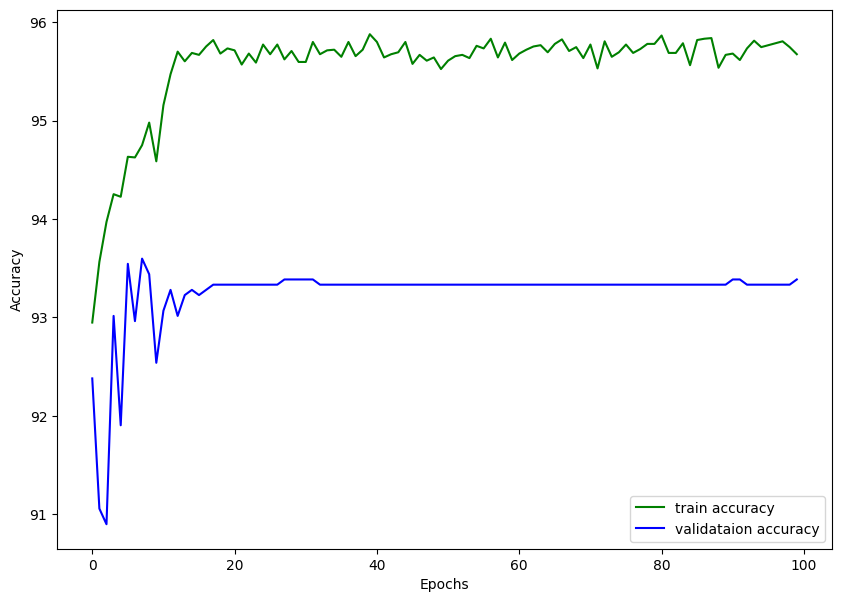

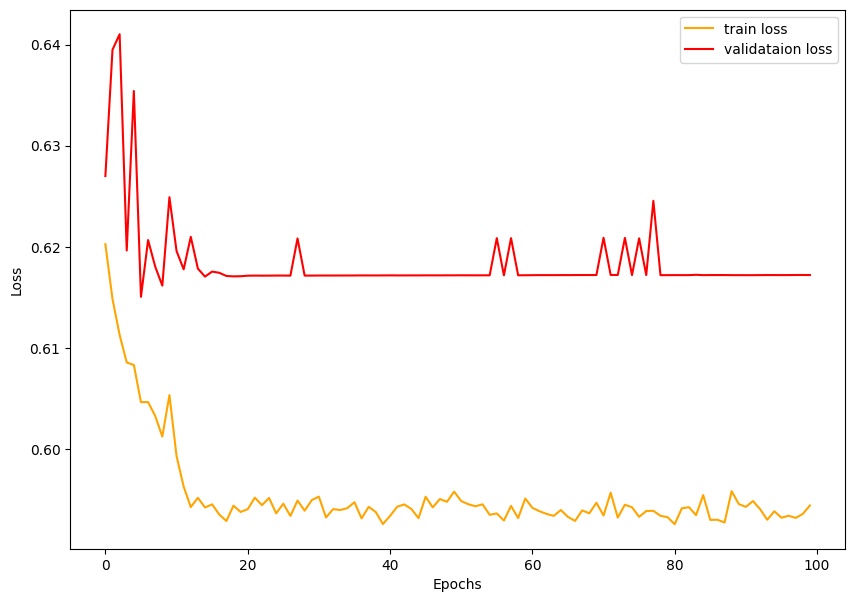

In [32]:
import torch.optim.lr_scheduler as lr_scheduler
writer = SummaryWriter(comment="LR_0.0001_BATCH_16_modelfusion_epoch100_v2")
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model_fusion.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model_fusion.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# Optimizer.
optimizer = optim.Adam(model_fusion.parameters(), lr=lr)
# Loss function.
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=3)
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model_fusion, train_loader,
                                            optimizer, criterion,True)
    writer.add_scalar("Loss/Train",train_epoch_loss,epoch)
    writer.add_scalar("Accuracy/Train",train_epoch_acc,epoch)
    valid_epoch_loss, valid_epoch_acc = validate(model_fusion, valid_loader,
                                                criterion,True)
    writer.add_scalar("Loss/valid",valid_epoch_loss,epoch)
    writer.add_scalar("Accuracy/valid",valid_epoch_acc,epoch)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    scheduler.step(valid_epoch_loss)

    # Save the trained model_fusion weights.
    save_model(epoch+1, model_fusion, optimizer, criterion, "feature_fusion_resnet50_lbp_v2")
# Save the loss and accuracy plots.
writer.flush()
save_plots(train_acc, valid_acc, train_loss, valid_loss, "feature_fusion_resnet50_lbp_v2")
print('TRAINING COMPLETE')
writer.close()

## Testing all the models on the Test Set 

In [23]:
def get_test_datasets(IMAGE_SIZE,TEST_DIR):
    """
    Function to prepare the Datasets.
    Returns the training and validation datasets along 
    with the class names.
    """
    dataset_test = datasets.ImageFolder(
        TEST_DIR, 
        transform=(get_test_transform(IMAGE_SIZE))
    )
    
    return dataset_test

def get_data_loaders_(dataset_test):
    """
    Prepares the training and validation data loaders.

    :param dataset_train: The training dataset.
    :param dataset_valid: The validation dataset.

    Returns the training and validation data loaders.
    """
    test_loader = DataLoader(
        dataset_test, batch_size=BATCH_SIZE,
        shuffle=True, num_workers=NUM_WORKERS
    )
    return test_loader



def get_test_transform(IMAGE_SIZE):
    test_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    ])
    return test_transform

def test(model, model_, testloader, criterion,fusion = False):
    model.eval()
    print('testing')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            if fusion:
                image = image.to(device)
                resnet_features = model_(image).detach()
                # print(resnet_features.shape)
                lbp_features = extract_lbp_features_batch(image)
                lbp_features = lbp_features.to(resnet_features.device)
                # print(lbp_features.shape)
                labels = labels.to(device)
                outputs = model(resnet_features,lbp_features)
            else:
                image = image.to(device)
                labels = labels.to(device)
                # Forward pass.
                outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

## Testing: Resnet50 - pretrained

In [7]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

model_1 = build_resnet_model(
    pretrained=False,
    fine_tune=False).to(device)

model_1.eval()
model_1.load_state_dict(torch.load('C:\Shanu\ResearchTopics\outputs\model_pretrainedresnet_79.pth')['model_state_dict'])
TEST_DIR = 'C:/Shanu/ResearchTopics/Group_5_water_slight/test/'

criterion = nn.CrossEntropyLoss()
dataset_test= get_test_datasets(IMAGE_SIZE,TEST_DIR)
testloader = get_data_loaders_(dataset_test)

test_loss_resnet ,_test_acc_resnet = test(model_1, testloader, criterion,fusion = False)

Computation device: cuda
[INFO]: Not loading pre-trained weights


C:\Users\ShanuD\Anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\ShanuD\Anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[INFO]: Freezing hidden layers...
testing


  0%|          | 0/140 [00:00<?, ?it/s]

In [9]:
print("The loss of the resnet pretrained model:",test_loss_resnet)
print("The Accuracy of the resnet pretrained model:",_test_acc_resnet)

The loss of the resnet pretrained model: 0.25657121246414527
The Accuracy of the resnet pretrained model: 90.5550581915846


## Testing: With resnet pretrained and LBP features

In [33]:
model_2 = FeatureFusionModel().to(device)
model_2.load_state_dict(torch.load('C:\Shanu\ResearchTopics\outputs\model_pretrainedfeature_fusion_resnet50_lbp_v1_69.pth')['model_state_dict'])
model_2_res=  build_resnet_feature_extractor(pretrained=True, fine_tune=False,as_feature_extractor=True).to(device)
model_2.eval()
model_2_res.eval()

test_loss_resnet_lbp ,test_acc_resnet_lbp = test(model_2, model_2_res,testloader,criterion,fusion = True)

print("The loss of the resnet pretrained model:",test_loss_resnet_lbp)
print("The Accuracy of the resnet pretrained model:",test_acc_resnet_lbp)

[INFO]: Loading pre-trained weights


C:\Users\ShanuD\Anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[INFO]: Freezing hidden layers...
2048
testing


  0%|          | 0/140 [00:00<?, ?it/s]

The loss of the resnet pretrained model: 0.7144157792840685
The Accuracy of the resnet pretrained model: 83.3034914950761


## Testing: With Resnet Finetuned and LBP features

In [27]:
model_3 = FeatureFusionModel().to(device)
model_3_res= build_resnet_feature_extractor(pretrained=False, fine_tune=False,as_feature_extractor=False).to(device)
model_3_res.load_state_dict(torch.load('C:\Shanu\ResearchTopics\outputs\model_pretrained_19_resnet50.pth')['model_state_dict'])
model_3.load_state_dict(torch.load('C:\Shanu\ResearchTopics\outputs\model_pretrainedfeature_fusion_resnet50_lbp_v2_99.pth')['model_state_dict'])
model_3_res.fc = nn.Identity()
model_3.eval()
model_3_res.eval()

test_loss_resnet_finetune_lbp ,test_acc_resnet_finetune_lbp = test(model_3, model_3_res,testloader,criterion,fusion = True)

print("The loss of the resnet pretrained model:",test_loss_resnet_finetune_lbp)
print("The Accuracy of the resnet pretrained model:",test_acc_resnet_finetune_lbp)

[INFO]: Not loading pre-trained weights
[INFO]: Freezing hidden layers...
2048
testing


  0%|          | 0/140 [00:00<?, ?it/s]

The loss of the resnet pretrained model: 0.632410135439464
The Accuracy of the resnet pretrained model: 91.89794091316024


## Inference Code

In [55]:
import numpy as np
import cv2
import torch
import glob as glob
import os
import time

from torchvision import transforms


seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Define computation device.
device = 'cpu'

model_3 = FeatureFusionModel().to(device)
model_3_res= build_resnet_feature_extractor(pretrained=False, fine_tune=False,as_feature_extractor=False).to(device)
model_3_res.load_state_dict(torch.load('C:\Shanu\ResearchTopics\outputs\model_pretrained_19_resnet50.pth')['model_state_dict'])
model_3.load_state_dict(torch.load('C:\Shanu\ResearchTopics\outputs\model_pretrainedfeature_fusion_resnet50_lbp_v2_99.pth')['model_state_dict'])
model_3_res.fc = nn.Identity()
model_3.eval()
model_3_res.eval()

transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    ])
image = cv2.imread("C:/Shanu/ResearchTopics/Group_5_water_slight/test/water_concrete_slight/202201262359428-water-concrete-slight.jpg")
# image = cv2.imread('C:/Shanu/ResearchTopics/Group_5_water_slight/test/water_asphalt_slight/202205031634442-water-asphalt-slight.jpg')
orig_image = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = orig_image.shape
# Apply the image transforms.
image_tensor = transform(image)
print(image_tensor.shape)
# Add batch dimension.
image_tensor = image_tensor.unsqueeze(0)
print(image_tensor.shape)

resnet_features = model_3_res(image_tensor).detach()
# print(resnet_features.shape)
lbp_features = extract_lbp_features_batch(image_tensor)

# Forward pass through model.
start_time = time.time()
outputs = model_3(resnet_features,lbp_features)
print(outputs)
end_time = time.time()
# Get the highest softmax probabilities.

preds = torch.argmax(outputs) 
print(preds)
print(int(outputs.squeeze(0).detach().numpy()[preds]))



[INFO]: Not loading pre-trained weights
[INFO]: Freezing hidden layers...
2048
torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([[4.2547e-40, 1.0000e+00, 0.0000e+00]], grad_fn=<SoftmaxBackward0>)
tensor(1)
1
